# Overview
    In addressing homelessness, understanding the geographic and demographic factors contributing to higher rates of unsheltered individuals is crucial for crafting effective intervention strategies. This part focuses on the analysis of homelessness hotspots in Los Angeles using detailed data on single adults experiencing homelessness. By identifying areas with the highest concentration of unsheltered individuals, city officials, policymakers, and service providers can better allocate resources, optimize shelter placements, and develop targeted outreach programs.

    This analysis combines geospatial data with homelessness statistics to visualize and categorize areas based on the severity of homelessness, particularly among single adults. By leveraging machine learning techniques, statistical analysis, and geospatial mapping, the project provides insights into which areas of Los Angeles are most in need of attention and support. The ultimate goal is to equip decision-makers with the information they need to reduce homelessness and improve the living conditions of vulnerable populations.

[Results Summary](#results_summary)

In [2]:
# Libraries for data work, geospatial operations, and visualization
import pandas as pd
from collections import defaultdict
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.patches as patches

Loading the shapefile into a GeoDataFrame and the CSV file into a regular DataFrame helps establish a clear view of each dataset's structure and content. This initial examination is important for confirming that the data is properly formatted and ready for the geospatial and statistical analyses needed to identify homelessness hotspots in Los Angeles.

In [4]:
# Load the shapefile into a GeoDataFrame and the CSV file into a regular DataFrame, then display the first few rows of each to understand their structure.
gdf = gpd.read_file('Split_Tracts.shp')
data_by_census_subtract = pd.read_csv('hc24-data-by-census-subtract.csv')
print(gdf.head())
print(data_by_census_subtract.head())

   OBJECTID    CT20  FIP23         CITY      CSA          CT20FIP23C  \
0      2882  101110  44000  Los Angeles  Tujunga  10111044000Tujunga   
1      2883  101122  44000  Los Angeles  Tujunga  10112244000Tujunga   
2      2884  101220  44000  Los Angeles  Tujunga  10122044000Tujunga   
3      2885  101221  44000  Los Angeles  Tujunga  10122144000Tujunga   
4      2886  101222  44000  Los Angeles  Tujunga  10122244000Tujunga   

     Shape__Are    Shape__Len  \
0  1.229617e+07  15082.853841   
1  2.845804e+07  31669.989984   
2  7.522647e+06  12693.428237   
3  3.811984e+06   9161.613517   
4  3.191371e+06   9980.600461   

                                            geometry  
0  POLYGON ((6471651.068 1918306.964, 6471940.821...  
1  POLYGON ((6477840.906 1917081.39, 6477828.62 1...  
2  POLYGON ((6477611.571 1915577.225, 6477591.852...  
3  POLYGON ((6474841.984 1915634.509, 6474838.988...  
4  POLYGON ((6475267.737 1915630.02, 6475266.465 ...  
  tract_split  Year              City 

Converting the 'tract_split' column in the CSV and the 'CT20' column in the shapefile to strings and merging the datasets integrates the geographic and statistical information into a unified format. This merging process, followed by the conversion to a GeoDataFrame, allows for spatial analysis by combining detailed census data with geospatial information. The resulting datase is now ready for further analysis to identify homelessness hotspots in Los Angeles.

In [6]:
# Convert the 'tract_split' column in the df and 'CT20' column in the GDF to strings for merging
data_by_census_subtract['tract_split'] = data_by_census_subtract['tract_split'].astype(str)
gdf['CT20'] = gdf['CT20'].astype(str)

# Merge the datasets and convert the merged df to a GDF with the specified geometry column
merged_gdf = data_by_census_subtract.merge(gdf, left_on='tract_split', right_on='CT20')
merged_gdf['City'] = merged_gdf['City'].fillna('Los Angeles')
merged_gdf = gpd.GeoDataFrame(merged_gdf, geometry='geometry')

print(merged_gdf.head())

  tract_split  Year              City  LACity    Community_Name  SPA  sd  cd  \
0      101110  2024  Los Angeles city       1  Los Angeles city    2   5   7   
1      101122  2024  Los Angeles city       1  Los Angeles city    2   5   7   
2      101220  2024  Los Angeles city       1  Los Angeles city    2   5   7   
3      101221  2024  Los Angeles city       1  Los Angeles city    2   5   7   
4      101222  2024  Los Angeles city       1  Los Angeles city    2   5   7   

   ca_ssd  us_cd  ...  totSheltPeople  OBJECTID    CT20  FIP23         CITY  \
0      20     30  ...               0      2882  101110  44000  Los Angeles   
1      20     30  ...               0      2883  101122  44000  Los Angeles   
2      20     30  ...               0      2884  101220  44000  Los Angeles   
3      20     30  ...               0      2885  101221  44000  Los Angeles   
4      20     30  ...               0      2886  101222  44000  Los Angeles   

       CSA          CT20FIP23C    Shape__Are

Calculating the mean and standard deviation for the 'totStreetSingAdult' column allows for the identification of homelessness hotspots by setting thresholds for categorization. By defining these thresholds and creating a 'hotspot' column, the dataset is categorized into Low, Medium, and High levels of homelessness severity. This classification helps in pinpointing areas with varying degrees of need, facilitating targeted intervention strategies for addressing homelessness in Los Angeles.

In [8]:
# Calculate the mean and standard deviation for the 'totStreetSingAdult' column to identify hotspots
mean_value = merged_gdf['totStreetSingAdult'].mean()
std_dev = merged_gdf['totStreetSingAdult'].std()

# Define thresholds for categorizing hotspots into Low, Medium, and High
thresholds = [mean_value + std_dev, mean_value + 2*std_dev]

# Create a new column 'hotspot' to categorize areas based on the number of single adults on the street
merged_gdf['hotspot'] = pd.cut(
    merged_gdf['totStreetSingAdult'],
    bins=[0, thresholds[0], thresholds[1], merged_gdf['totStreetSingAdult'].max()],
    labels=['Low', 'Medium', 'High']
)

print(merged_gdf['hotspot'].head())

0    Low
1    Low
2    Low
3    Low
4    Low
Name: hotspot, dtype: category
Categories (3, object): ['Low' < 'Medium' < 'High']


Defining a custom color map and normalization for plotting enhances the visualization of homelessness severity. By setting specific colors and boundaries, the custom color map provides a clear and intuitive representation of different hotspot categories—Low, Medium, and High. This approach ensures that the visual distinctions between varying levels of severity are easily discernible, aiding in the effective communication of the data's insights.

In [10]:
# Define a custom color map and normalization for plotting
cmap = mcolors.ListedColormap(['lightblue', 'orange', 'red'])
bounds = [0, 1, 2, 3]  # Boundaries for the color map
norm = mcolors.BoundaryNorm(bounds, cmap.N)

Plotting the GeoDataFrame visually distinguishes areas based on their level of homelessness severity. By using a clear color scheme the map effectively conveys the distribution of hotspots—Low, Medium, and High—across Los Angeles. This visualization aids in quickly identifying regions with varying degrees of need, which is essential for strategic planning and resource allocation.

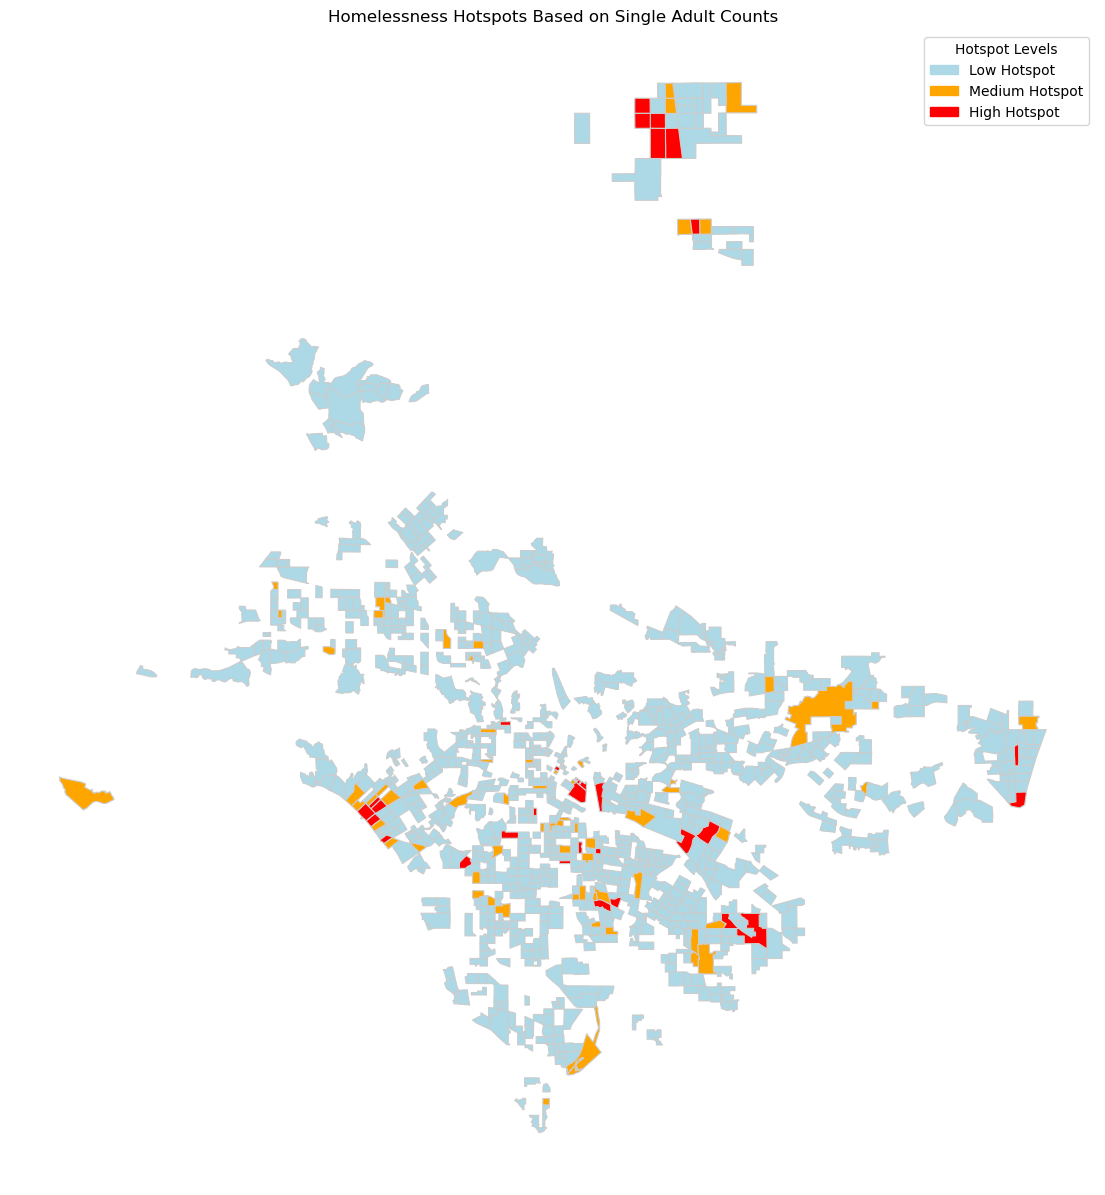

In [12]:
# Plot the GDF with the custom color map and normalization
fig, ax = plt.subplots(figsize=(15, 15))
base = merged_gdf.plot(column='hotspot', cmap=cmap, linewidth=0.8, ax=ax, edgecolor='0.8', legend=False)
ax.set_axis_off()
plt.title('Homelessness Hotspots Based on Single Adult Counts')

# Legend
patches_list = [
    patches.Patch(color='lightblue', label='Low Hotspot'),
    patches.Patch(color='orange', label='Medium Hotspot'),
    patches.Patch(color='red', label='High Hotspot')
]
plt.legend(handles=patches_list, loc='upper right', title='Hotspot Levels')
plt.show()

Classifying and formatting hotspot entries by iterating through each row of the GeoDataFrame allows for a detailed breakdown of homelessness severity across different areas. By categorizing entries into Low, Medium, and High hotspot lists, this approach provides a structured view of the data, making it easier to identify and prioritize areas for intervention. Outputting these categorized entries helps in reviewing and communicating specific hotspots, which is crucial for effective decision-making and targeted resource allocation.

In [14]:
# To store hotspot entries
low_hotspots = []
medium_hotspots = []
high_hotspots = []

# Goes through each row in the GDF to classify and format hotspots
for idx, row in merged_gdf.iterrows():
    tract_split = row['tract_split']
    tot_street_sing_adult = row['totStreetSingAdult']
    city = row['City']  # Extract city information
    formatted_entry = f"{city}({tract_split}): {tot_street_sing_adult}" # Format entry

    # Append to respective lists based on hotspot category
    if row['hotspot'] == 'Low':
        low_hotspots.append(formatted_entry)
    elif row['hotspot'] == 'Medium':
        medium_hotspots.append(formatted_entry)
    elif row['hotspot'] == 'High':
        high_hotspots.append(formatted_entry)

print("Low Hotspots:")
for entry in low_hotspots:
    print(entry)
print("\nMedium Hotspots:")
for entry in medium_hotspots:
    print(entry)
print("\nHigh Hotspots:")
for entry in high_hotspots:
    print(entry)

Low Hotspots:
Los Angeles city(101110): 7
Los Angeles city(101122): 1
Los Angeles city(101220): 3
Los Angeles city(101221): 2
Los Angeles city(101222): 3
Los Angeles city(101400): 2
Los Angeles city(103102): 2
Los Angeles city(103102): 2
Los Angeles city(103300): 2
Los Angeles city(103401): 3
Los Angeles city(103402): 4
Los Angeles city(104103): 1
Los Angeles city(104310): 2
Los Angeles city(104322): 2
Los Angeles city(104401): 1
Los Angeles city(104500): 2
Los Angeles city(104822): 5
Los Angeles city(106112): 6
Los Angeles city(106113): 2
Los Angeles city(106114): 1
Los Angeles city(106642): 1
Los Angeles city(106649): 1
Los Angeles city(107010): 1
Los Angeles city(107020): 5
Los Angeles city(108104): 2
Los Angeles city(109500): 3
Los Angeles city(109603): 1
Los Angeles city(111201): 1
Los Angeles city(111202): 1
Los Angeles city(111304): 1
Los Angeles city(113212): 5
Los Angeles city(113213): 7
Los Angeles city(113238): 2
Los Angeles city(113303): 7
Los Angeles city(113323): 2
Los An

Collecting and sorting data for high hotspots helps identify the tracts with the highest concentrations of unsheltered single adults. By focusing on 'High' hotspots and sorting them by the number of individuals, this approach highlights the most critical areas in need of attention. Outputting the top 10 tracts with the highest counts provides a clear list of the most severe hotspots, aiding in targeted intervention and resource allocation efforts.

In [16]:
# Will store high hotspot data with tract_split and city
high_hotspot_tracts = []

# Goes through each row in the GDF to collect high hotspots data
for idx, row in merged_gdf.iterrows():
    tract_split = row['tract_split']
    tot_street_sing_adult = row['totStreetSingAdult']
    city = row['City']  # Get the city for each tract
    
    # Only want to look at 'High' hotspots
    if row['hotspot'] == 'High':
        # Append tuple of (tract_split, city, tot_street_sing_adult) to the list
        high_hotspot_tracts.append((tract_split, city, tot_street_sing_adult))

sorted_high_hotspot_tracts = sorted(high_hotspot_tracts, key=lambda x: -x[2])

# Output the top 10 tracts with the highest totalStreetSingAdult in High Hotspots
print("Top 10 tracts with the highest Single Adults on the Street in High Hotspots:")
for tract_split, city, total in sorted_high_hotspot_tracts[:10]:
    print(f"{city}, Tract {tract_split}: {total}")

Top 10 tracts with the highest Single Adults on the Street in High Hotspots:
Los Angeles city, Tract 206303: 244
Santa Monica city, Tract 701902: 202
Los Angeles city, Tract 226002: 189
Los Angeles city, Tract 206301: 140
Los Angeles city, Tract 206302: 99
Los Angeles city, Tract 277100: 76
Santa Fe Springs city, Tract 980034: 60
Los Angeles city, Tract 231210: 45
Santa Monica city, Tract 701702: 43
Santa Monica city, Tract 702002: 43


Aggregating data for high hotspots by city provides a summary of total unsheltered single adults across different areas. This approach consolidates the number of individuals in 'High' hotspot tracts, allowing for a clearer view of which cities experience the most significant homelessness issues. Outputting these aggregated results helps prioritize cities for targeted interventions and resource allocation, focusing efforts on areas with the highest total need.

In [18]:
# Store aggregated high hotspot data
high_hotspot_aggregations = defaultdict(int)

# Goes through each row in the GDF to classify and aggregate high hotspots
for idx, row in merged_gdf.iterrows():
    city = row['City']
    total_home = row['totStreetSingAdult']
    if row['hotspot'] == 'High':
        high_hotspot_aggregations[city] += total_home

# Outputs the aggregated results for high hotspots
def print_high_hotspots(aggregations):
    print("Total homeless in High Hotspots:")
    # Sort the cities by total in descending order
    sorted_cities = sorted(aggregations.items(), key=lambda x: -x[1])
    for city, total in sorted_cities:
        print(f"{city}: {total}")
        
print_high_hotspots(high_hotspot_aggregations)


Total homeless in High Hotspots:
Los Angeles city: 1020
Santa Monica city: 322
Lancaster city: 166
Lynwood city: 62
Santa Fe Springs city: 60
Pomona city: 59
Palmdale city: 43
Norwalk city: 36
Montebello city: 34
Huntington Park city: 33
Pico Rivera city: 30
Los Angeles: 30


<a id='results_summary'></a>
# Results Summary

    This analysis sheds light on the geographic areas in Los Angeles County where street homelessness among single adults is most concentrated. By identifying and evaluating these high-density regions, we can gain valuable insight into where homelessness interventions and resources are most urgently needed.

    The data highlights several tracts in both Los Angeles City and Santa Monica City as having the highest concentrations of homeless single adults. The tract with the largest number of single adults experiencing homelessness is Tract 206303 in Los Angeles City, with a total of 244 individuals counted. Following closely is Tract 701902 in Santa Monica City, which recorded 202 homeless individuals. Other notable tracts include Tract 226002 in Los Angeles City with 189 individuals and Tract 206301, also in Los Angeles, with 140 individuals. The top ten tracts with the highest counts of single adults on the street include multiple areas within Los Angeles City, as well as tracts in Santa Monica City and Santa Fe Springs City. This suggests that homelessness is heavily concentrated within a small number of specific tracts, particularly in Los Angeles, which dominates the top of the list.

    In terms of overall city-level analysis, Los Angeles City stands out as the area with the highest concentration of street homelessness among single adults, accounting for a total of 1,020 individuals across the identified high hotspot tracts. Santa Monica City ranks second, with 322 individuals in similar high hotspot areas. Other cities with notable concentrations of street homelessness include Lancaster with 166 individuals, Lynwood with 62, and Santa Fe Springs with 60. While smaller than Los Angeles and Santa Monica, these cities also face significant challenges and require attention to prevent the problem from escalating.

    The data clearly points to Los Angeles City as the epicenter of street homelessness among single adults in Los Angeles County. A few key tracts in this city account for the majority of the homeless population, suggesting that focused intervention in these areas could have a substantial impact. Similarly, Santa Monica City shows several high-density tracts that would benefit from targeted resource allocation and outreach efforts. Although smaller cities like Lancaster, Lynwood, and Santa Fe Springs have lower total numbers, the presence of homelessness in these areas is still significant, and localized interventions could prevent further growth of the issue.

    In terms of strategic implications, it is clear that any intervention aimed at reducing street homelessness in Los Angeles County must begin with a focus on the high hotspot areas in Los Angeles City and Santa Monica City. These cities account for the vast majority of homeless single adults in high-density tracts, making them critical regions for targeted outreach, shelter expansion, and housing programs. In smaller cities like Lancaster and Lynwood, efforts should be more localized, focusing on providing immediate support to those already experiencing homelessness while implementing preventive measures to curb future growth.

    To ensure continued effectiveness in addressing street homelessness, it will be essential to monitor these high hotspot areas closely. As the homeless population shifts, resources and interventions must adapt to meet the changing landscape, ensuring that areas with growing needs receive adequate support.